In [37]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')

In [38]:
df = pd.read_csv('data/data_final_preprocessed.csv')

<h2> Хи-квадрат </h2>

In [39]:
contingency_table = pd.crosstab(df['pro_flg'], df['success_flg'])
print("Contingency Table:")
print(contingency_table)

chi2, p, dof, expected = chi2_contingency(contingency_table, correction=True)

print(f"X^2 Statistic: {chi2}")
print(f"P-value: {p}")

Contingency Table:
success_flg     0    1
pro_flg               
0            5460  800
1            2972  285
X^2 Statistic: 34.03430513703083
P-value: 5.414891998768151e-09


In [40]:
import pandas as pd
from scipy.stats import chi2_contingency

df1 = df.dropna(subset=['gender_cd'])

for col in df1['gender_cd'].unique():
    print(f"Value = {col}")
    df_filtered = df1[df1['gender_cd'] == col]
    contingency_table = pd.crosstab(df_filtered['pro_flg'], df_filtered['success_flg'])
    print("Contingency Table:")
    print(contingency_table)
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"X^2 Statistic: {chi2}")
    print(f"P-value: {p}")
    print("-" * 50)

Value = 1.0
Contingency Table:
success_flg     0    1
pro_flg               
0            2714  409
1            1656  181
X^2 Statistic: 11.302255766387912
P-value: 0.0007741298118308457
--------------------------------------------------
Value = 0.0
Contingency Table:
success_flg     0    1
pro_flg               
0            2746  391
1            1316  104
X^2 Statistic: 26.14623636849535
P-value: 3.165134279534092e-07
--------------------------------------------------


<h2> Логрег </h2>

Что мы исследуем в модели?
* возраст
* гендер
* размер населенного пункта
* флаг иностранного гражданина(мало иностранцев, сильный дисбаналанс в группах)
* флаг предпринимателя
* флаг путешественника
* наличие партнера
* количество детей
* тип основной недвижимости
* подписка
* доход(мало данных, не использую)

In [41]:
# выводим процент успехов во всем датасете
df['success_flg'].sum() / df.shape[0] * 100

np.float64(11.400651465798045)

<h4> 11 % данных - успехи, некритичный дисбаланс классов, поэтому ничего с этим не делаем </h4>

In [42]:
y = df['success_flg']
X = df[['gender_cd',  'entrepreneur_flg',
          'auto_flg', 'traveler_flg', 'partnership_flg', 'child_amt', 'realty_type', 'pro_flg', 'age', 'region_category']]

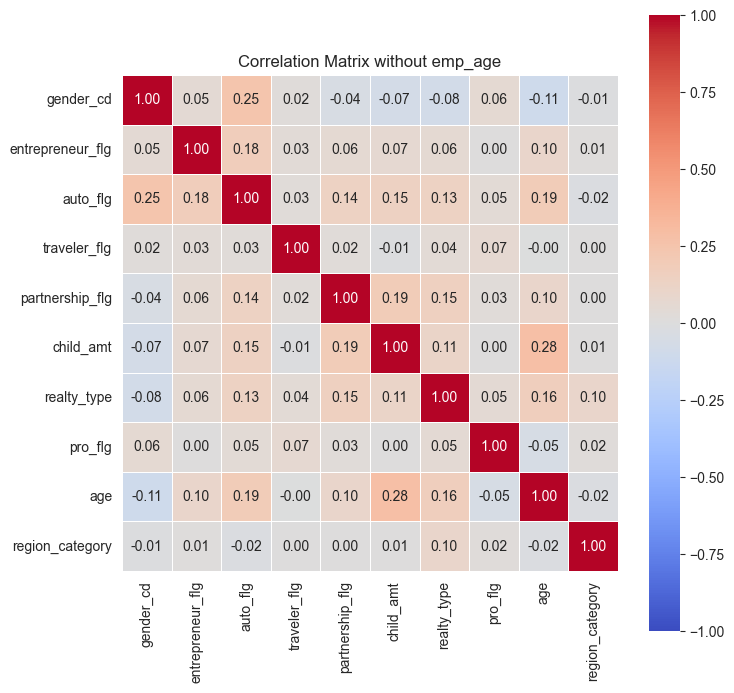

In [43]:
correlation_matrix = X.corr(method='spearman')
plt.figure(figsize=(8, 8))
plt.title('Correlation Matrix without emp_age')
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, vmin=-1, vmax=1, square=True)
plt.show()

In [44]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# Вычисление VIF
vif_results = calculate_vif(X)


print(vif_results)
threshold = 10  # Предельное значение VIF
high_vif_features = vif_results[vif_results['VIF'] > threshold]
print("\nПризнаки с высоким VIF (VIF > {}):".format(threshold))
print(high_vif_features)

            Feature       VIF
0         gender_cd  2.148498
1  entrepreneur_flg  1.199938
2          auto_flg  2.324574
3      traveler_flg  1.026496
4   partnership_flg  4.516390
5         child_amt  1.427991
6       realty_type  2.212978
7           pro_flg  1.516547
8               age  7.314922
9   region_category  6.627662

Признаки с высоким VIF (VIF > 10):
Empty DataFrame
Columns: [Feature, VIF]
Index: []


In [45]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9517 entries, 0 to 9516
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender_cd         9517 non-null   float64
 1   entrepreneur_flg  9517 non-null   float64
 2   auto_flg          9517 non-null   float64
 3   traveler_flg      9517 non-null   float64
 4   partnership_flg   9517 non-null   float64
 5   child_amt         9517 non-null   float64
 6   realty_type       9517 non-null   float64
 7   pro_flg           9517 non-null   int64  
 8   age               9517 non-null   float64
 9   region_category   9517 non-null   int64  
dtypes: float64(8), int64(2)
memory usage: 743.6 KB


Нормализуем возраст и количество детей для корректной интерпретации коэффициентов и результатов

In [46]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [47]:
numeric_features = X.select_dtypes(include=['int', 'float']).columns
print("Числовые признаки:", numeric_features)

# Нормализация числовых признаков
scaler = StandardScaler()  # Или MinMaxScaler() для минимакс-нормализации
X[numeric_features] = scaler.fit_transform(X[numeric_features])

Числовые признаки: Index(['gender_cd', 'entrepreneur_flg', 'auto_flg', 'traveler_flg',
       'partnership_flg', 'child_amt', 'realty_type', 'pro_flg', 'age',
       'region_category'],
      dtype='object')


In [48]:
X = sm.add_constant(X)

model = sm.Logit(y, X)
result = model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.348918
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            success_flg   No. Observations:                 9517
Model:                          Logit   Df Residuals:                     9506
Method:                           MLE   Df Model:                           10
Date:                Mon, 16 Dec 2024   Pseudo R-squ.:                 0.01661
Time:                        15:20:51   Log-Likelihood:                -3320.7
converged:                       True   LL-Null:                       -3376.7
Covariance Type:            nonrobust   LLR p-value:                 1.957e-19
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -2.0966      0.034    -62.385      0.000      -2.162      -2.031
gender_cd  

In [49]:
print("\nИнтерпретация коэффициентов:")
for feature, coef in zip(result.params.index, result.params):
    odds_ratio = np.exp(coef)
    print(f"{feature}: Коэффициент = {coef:.4f}, Шансы = {odds_ratio:.4f}")


Интерпретация коэффициентов:
const: Коэффициент = -2.0966, Шансы = 0.1229
gender_cd: Коэффициент = 0.0855, Шансы = 1.0892
entrepreneur_flg: Коэффициент = -0.0325, Шансы = 0.9681
auto_flg: Коэффициент = -0.1397, Шансы = 0.8696
traveler_flg: Коэффициент = -0.0248, Шансы = 0.9755
partnership_flg: Коэффициент = -0.0533, Шансы = 0.9481
child_amt: Коэффициент = 0.0601, Шансы = 1.0620
realty_type: Коэффициент = -0.1955, Шансы = 0.8224
pro_flg: Коэффициент = -0.1867, Шансы = 0.8297
age: Коэффициент = 0.0271, Шансы = 1.0275
region_category: Коэффициент = -0.0479, Шансы = 0.9532


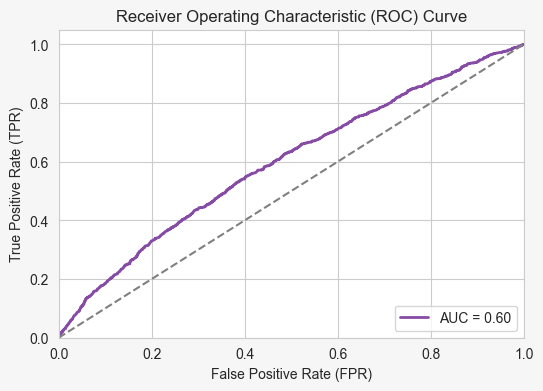

In [50]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities from the probit model
y_pred_prob = result.predict(X)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y, y_pred_prob)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 4))
sns.set_style("whitegrid")  # Настройка стиля фона

# Устанавливаем цвет фона
plt.gcf().set_facecolor('#F6F6F6')
plt.plot(fpr, tpr, color='#864BA5', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [51]:
# Статистика отношения правдоподобия
likelihood_ratio_stat = result.llr  # Статистика
p_value = result.llr_pvalue  # p-значение

print(f"Статистика отношения правдоподобия: {likelihood_ratio_stat}")
print(f"p-значение: {p_value}")

Статистика отношения правдоподобия: 112.15854101310379
p-значение: 1.9570537756206304e-19
